In [1]:
using Revise
using Rocket
using ReactiveMP
using GraphPPL
using Distributions
using Random
# using BenchmarkTools
import ProgressMeter
using LinearAlgebra

┌ Info: Precompiling ReactiveMP [a194aa59-28ba-4574-a09c-4a745416d6e3]
└ @ Base loading.jl:1317


In [2]:
# Multivariate update
ReactiveMP.@rule NormalMixture{N}(:out, Marginalisation) (q_switch::Any, q_m::NTuple{N,  MultivariateNormalDistributionsFamily}, q_p::NTuple{N, Wishart }) where { N } = begin
    πs = probvec(q_switch)
    d  = ndims(first(q_m))
    w  = mapreduce(x -> x[1]*mean(x[2]), +, zip(πs, q_p))
    xi = mapreduce(x -> x[1]*mean(x[2])*mean(x[3]), +, zip(πs, q_p, q_m))
    return MvNormalWeightedMeanPrecision(xi, w)
end

## Switching AR

In [3]:
@model [ default_factorisation = MeanField() ] function switching_ar(inputs, outputs, nmixtures, nbuckets,
                                                                     priors_as, priors_bs,
                                                                     priors_ms, priors_ws)

    n = length(outputs)
    A ~ MatrixDirichlet(ones(nmixtures, nmixtures))

    z_0 ~ Categorical(fill(1.0 / nmixtures, nmixtures))

    as = randomvar(nmixtures, prod_strategy = FoldRightProdStrategy(), constraint=EM())
    bs = randomvar(nmixtures, prod_strategy = FoldRightProdStrategy())
    ms = randomvar(nmixtures)
    ws = randomvar(nmixtures)

    for i in 1:nmixtures
        as[i] ~ GammaShapeRate(shape(priors_as[i]), rate(priors_as[i]))
        bs[i] ~ GammaShapeRate(shape(priors_bs[i]), rate(priors_bs[i]))
        ms[i] ~ MvNormalMeanCovariance(mean(priors_ms[i]), cov(priors_ms[i]))
        ws[i] ~ Wishart(priors_ws[i][1], priors_ws[i][2])
    end

    z  = randomvar(nbuckets)
    γ  = randomvar(nbuckets)
    θ  = randomvar(nbuckets)
    dp = randomvar(n)
    x  = datavar(Vector{Float64}, n)
    y  = datavar(Float64, n)

    meta = GammaMixtureNodeMetadata(EM())

    tas = tuple(as...)
    tbs = tuple(bs...)
    tms = tuple(ms...)
    tws = tuple(ws...)

    z_prev = z_0
    for i in 1:nbuckets
        z[i] ~ Transition(z_prev, A) where { q = q(out, in)q(a) }
        γ[i] ~ GammaMixture(z[i], tas, tbs) where { meta = meta }
        θ[i] ~ GaussianMixture(z[i], tms, tws) where { q = MeanField() }
        z_prev = z[i]
    end
    
    k = div(n + ARorder, nbuckets)

    for i in 1:n
        r     = div(i - 1, k) + 1
        dp[i] ~ dot(x[i], θ[r])
        y[i]  ~ NormalMeanPrecision(dp[i], γ[r]) 
    end

    scheduler = schedule_updates(as, bs, ms, ws)
#     scheduler = schedule_updates(ms, ws, as, bs, z, θ, γ, A)

    return scheduler, z, A, as, bs, ms, ws, θ, γ, y, x
end

switching_ar (generic function with 1 method)

In [4]:
function inference_ar(inputs, outputs, nmixtures, nbuckets, n_its, priors_as, priors_bs, priors_ms, priors_ws)
    n = length(outputs)
    ARorder = size(priors_ms[1])[1]

    model, (scheduler, z, A, as, bs, ms, ws, θs, γs, y, x) = switching_ar(inputs, outputs, nmixtures, nbuckets,
                                                                          priors_as, priors_bs,
                                                                          priors_ms, priors_ws, options=(limit_stack_depth=100,));
    

    mzs     = keep(Vector{Marginal})
    mA      = keep(Marginal)
    mas     = keep(Vector{Marginal})
    mbs     = keep(Vector{Marginal})
    mms     = keep(Vector{Marginal})
    mws     = keep(Vector{Marginal})
    mθs     = keep(Vector{Marginal})
    mγs     = keep(Vector{Marginal})
    fe      = ScoreActor(Float64)

    mA_sub     = subscribe!(getmarginal(A), mA)
    mz_sub     = subscribe!(getmarginals(z), mzs)
    as_sub     = subscribe!(getmarginals(as), mas)
    bs_sub     = subscribe!(getmarginals(bs), mbs)
    ms_sub     = subscribe!(getmarginals(ms), mms)
    ws_sub     = subscribe!(getmarginals(bs), mws)
    θs_sub     = subscribe!(getmarginals(θs), mθs)
    γs_sub     = subscribe!(getmarginals(γs), mγs)

    # fe_scheduler = PendingScheduler()
    fe_sub     = subscribe!(score(Float64, BetheFreeEnergy(), model), fe)

    setmarginal!(A, vague(MatrixDirichlet, (nmixtures, nmixtures)))

    for (i, (a, b, m, w)) in enumerate(zip(as, bs, ms, ws))
        setmarginal!(a, infgamma(Float64, 1.0, ϵ = 1.0))
        setmarginal!(b, infgamma(Float64, 1.0, ϵ = 1.0))
        setmarginal!(m, vague(MvNormalMeanCovariance, ARorder))
        setmarginal!(w, vague(Wishart, ARorder))
    end

    for (θ, γ) in zip(θs, γs)
        setmarginal!(θ, vague(MvNormalMeanCovariance, ARorder))
        setmarginal!(γ, vague(Gamma))
    end

    release!(scheduler)
    
    ProgressMeter.@showprogress for i in 1:n_its
        update!(x, inputs)
        update!(y, outputs)
        release!(scheduler)
        # release!(fe_scheduler)
    end


    return map(getvalues, (mzs, mγs, mθs, mA, mas, mbs, mms, mws, fe))
end

inference_ar (generic function with 1 method)

In [5]:
ReactiveMP.release!(::Nothing) = nothing

## Generate AR

In [80]:
using Random
Random.seed!(22)

infgamma(T, x; ϵ = 1e-3) = GammaShapeRate{T}(x^2 / ϵ, x / ϵ)

using Distributions
ARorder = 2

γs = [1.0, 0.1]
# γs = [0.01, 0.1, 10.0, 1.0]
θs = [[0.3, 0.1], [0.1, -0.2]]
# θs = [0.9, 0.3, -0.3, 0.1]

@assert length(γs) == length(θs)

nmixtures = length(γs)
n_samples = 5000
x = ones(ARorder)
# x = [1.0, 2.0]

n_slice_n = 500

for i in 1:n_samples
    i_mixture = rem(div(i, n_slice_n), nmixtures) + 1
    dist = Normal(dot(θs[i_mixture], x[end:-1:end-ARorder+1]), sqrt(1/γs[i_mixture]))
    push!(x, rand(dist))
end

inputs = x[1:n_samples+1]
outputs = circshift(x, -1)

inputs = inputs[1:end-1]
outputs = outputs[2:end-1]
;

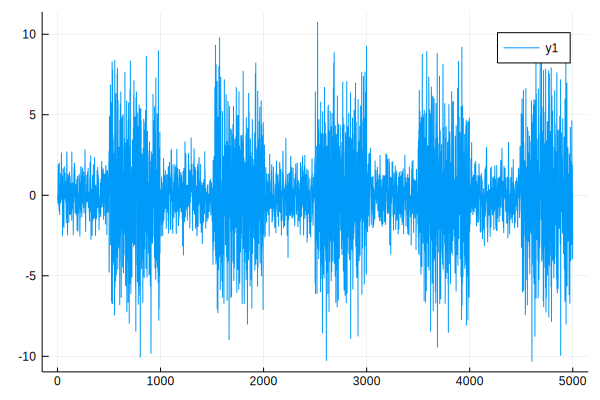

In [81]:
using Plots
plot(outputs)

In [82]:
inputs_ = [inputs[i+ARorder-1:-1:i] for i in 1:length(inputs)-ARorder]
outputs_ = outputs[1:end-ARorder]

4998-element Vector{Float64}:
 -0.29472456411623216
 -0.17911498020485722
 -0.017556217419763737
 -0.5226675849002765
  0.7051574669722201
  1.4477141287281774
  1.9313761232833366
  0.17326851665356158
 -0.059378190471803954
 -0.06088544905185177
  1.8212866401904688
 -0.6667933615601891
  1.2334853704401372
  ⋮
 -3.0806546226424576
 -2.854437817444758
  1.1125838954415783
 -0.8055893964468788
  4.651618499851883
  0.2778811272917747
 -3.0103765783110585
 -2.767464140943432
 -1.3277156184230035
  1.879703610520619
 -1.0553371498323803
  0.1495191942716852

In [83]:
csep = 10.0

priors_as = map(γ -> infgamma(Float64, γ*csep), γs)
priors_bs = map(_ -> infgamma(Float64, csep), γs)

priors_ms = map(θ -> MvGaussianMeanPrecision(θ, diageye(ARorder)), θs)
priors_ws = map(_ -> (ARorder, 1e4*diageye(ARorder)), θs)

# mixing = [0.5, 0.5]
# dists = [convert(Gamma, GammaShapeRate{Float64}(γs[j]*1e2, 1e2)) for j in 1:length(mixing)]
# p = histogram(rand(MixtureModel(Gamma[dists... ], mixing), 10000), bins=100)
#
# dists = [Normal(θs[j], sqrt(inv(1e4))) for j in 1:length(mixing)]
# p = histogram(rand(MixtureModel(Normal[dists... ], mixing), 10000), bins=100)

# ReactiveMP.is_clamped(tuple::Tuple) = all(ReactiveMP.is_clamped, collect(tuple))
# ReactiveMP.is_initial(tuple::Tuple) = all(ReactiveMP.is_initial, collect(tuple))

@time mzs, mγs, mθs, mA, mas, mbs, mms, mws, mfe = inference_ar(inputs_, outputs_, nmixtures, 500, 100, priors_as, priors_bs, priors_ms, priors_ws);

Progress:  99%|████████████████████████████████████████▋|  ETA: 0:00:00

 27.803162 seconds (137.88 M allocations: 8.992 GiB, 24.00% gc time, 0.33% compilation time)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:27


In [84]:
mean(mA[end])

2×2 Matrix{Float64}:
 0.976189   0.0199117
 0.0238112  0.980088

In [85]:
minimum(mean.(mγs[end]))

0.0451560558090743

In [86]:
mean.(mθs[end])

500-element Vector{Vector{Float64}}:
 [0.3125547595297289, 0.06793448849564576]
 [0.28311720740570534, 0.08904988307564314]
 [0.2970650053138572, 0.08346109787133082]
 [0.31264940402690783, 0.07618761288531736]
 [0.29790448650342627, 0.08346367248039219]
 [0.3042780936579573, 0.07081448591576217]
 [0.3096110490592221, 0.07047263952139607]
 [0.29818183811453375, 0.0812243564772119]
 [0.31093165616070717, 0.06715677735951175]
 [0.31814605922055283, 0.06614606864288156]
 [0.30875800900707556, 0.06893130551505264]
 [0.295903362222071, 0.06954411054361243]
 [0.3043642138711633, 0.0755217259224446]
 ⋮
 [0.07151407487683095, -0.20361348068662344]
 [0.077247234611554, -0.20011160197391017]
 [0.08231260766830026, -0.20990528651326587]
 [0.07825090016007837, -0.21028318201737103]
 [0.06543946510890002, -0.18786209845928245]
 [0.05937950422112781, -0.21536576628881132]
 [0.0806442961203646, -0.20366267662166912]
 [0.0791161638493883, -0.20317980322257204]
 [0.09592467260828262, -0.211177881024604

In [87]:
using Plots

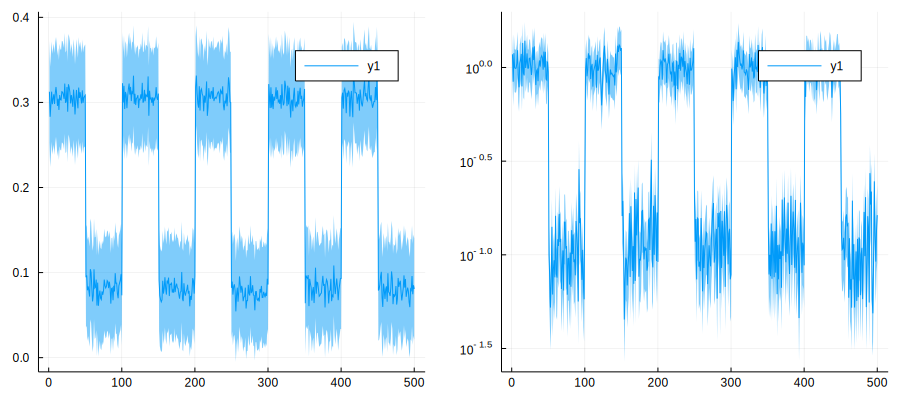

In [88]:
dim(n) = (x) -> map(i -> i[n], x)
index = 1
p1 = plot(mean.(mθs[end]) |> dim(index), ribbon = std.(mθs[end]) |> dim(index))
p2 = plot(mean.(mγs[end]), ribbon = std.(mγs[end]), yscale = :log10)

plot(p1, p2, size = (900, 400))

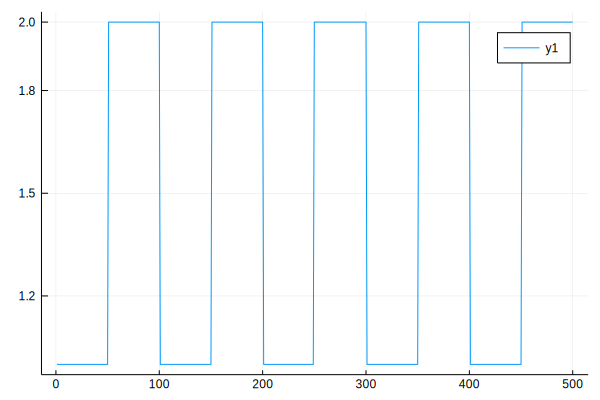

In [89]:
plot(mean.(mzs[end]))

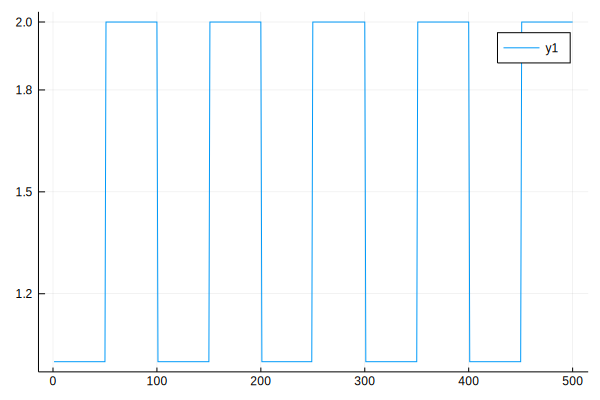

In [90]:
plot(round.(mean.(mzs[end])))

In [91]:
mean.(mzs[end])

500-element Vector{Float64}:
 1.0000000000010185
 1.0000000000010185
 1.0000000000010185
 1.0000000000010185
 1.0000000000010185
 1.0000000000010185
 1.0000000000010185
 1.0000000000010185
 1.0000000000010185
 1.0000000000010185
 1.0000000000010185
 1.0000000000010185
 1.0000000000010185
 ⋮
 1.9999999999989777
 1.9999999999989777
 1.9999999999989777
 1.9999999999989777
 1.9999999999989777
 1.9999999999989777
 1.9999999999989777
 1.9999999999989777
 1.9999999999989777
 1.9999999999989777
 1.9999999999989777
 1.9999999999990001

mfe[end - 4:end] = [10257.57664483357, 10257.511236730705, 10257.446866204285, 10257.38353361667, 10257.321188135644]


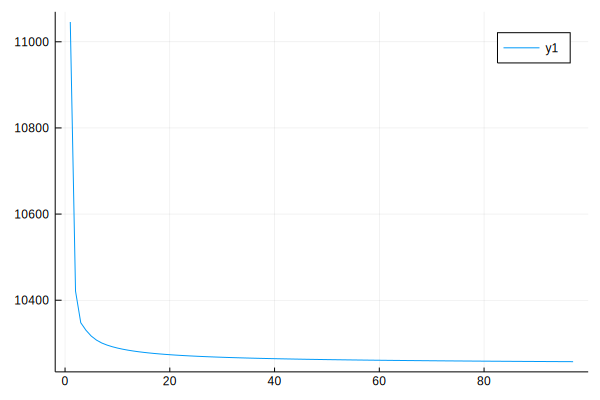

In [92]:
@show mfe[end-4:end]
plot(mfe[4:end])